**IDPS FOR WDS**

Step 1: Load & Explore Data

In [ ]:
pip install tensorflow


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

# Load datasets (Upload manually in Colab first)
df_normal = pd.read_csv("/content/drive/MyDrive/CWDS_DEMO/BATADAL Datasets/BATADAL_normal.csv", parse_dates=['DATETIME'], dayfirst=True)
df_attack = pd.read_csv("/content/drive/MyDrive/CWDS_DEMO/BATADAL Datasets/BATADAL_train.csv", parse_dates=['DATETIME'], dayfirst=True)

# Display basic info
print("Normal Data:")
print(df_normal.info(), "\n")
print("Attack Data:")
print(df_attack.info(), "\n")

# Display first few rows
df_normal.head(), df_attack.head()


<ipython-input-1-b2f67b9571c0>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_normal = pd.read_csv("/content/drive/MyDrive/CWDS_DEMO/BATADAL Datasets/BATADAL_normal.csv", parse_dates=['DATETIME'], dayfirst=True)
<ipython-input-1-b2f67b9571c0>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_attack = pd.read_csv("/content/drive/MyDrive/CWDS_DEMO/BATADAL Datasets/BATADAL_train.csv", parse_dates=['DATETIME'], dayfirst=True)


Normal Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8761 entries, 0 to 8760
Data columns (total 45 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DATETIME  8761 non-null   datetime64[ns]
 1   L_T1      8761 non-null   float64       
 2   L_T2      8761 non-null   float64       
 3   L_T3      8761 non-null   float64       
 4   L_T4      8761 non-null   float64       
 5   L_T5      8761 non-null   float64       
 6   L_T6      8761 non-null   float64       
 7   L_T7      8761 non-null   float64       
 8   F_PU1     8761 non-null   float64       
 9   S_PU1     8761 non-null   int64         
 10  F_PU2     8761 non-null   float64       
 11  S_PU2     8761 non-null   int64         
 12  F_PU3     8761 non-null   int64         
 13  S_PU3     8761 non-null   int64         
 14  F_PU4     8761 non-null   float64       
 15  S_PU4     8761 non-null   int64         
 16  F_PU5     8761 non-null   int64         
 17  S

(             DATETIME      L_T1      L_T2      L_T3      L_T4      L_T5  \
 0 2014-01-06 00:00:00  0.509730  2.049003  3.191145  2.792634  2.656091   
 1 2014-01-06 01:00:00  0.412580  2.009072  3.642565  2.831673  3.126387   
 2 2014-01-06 02:00:00  0.320112  1.986093  4.140192  3.256733  3.574601   
 3 2014-01-06 03:00:00  0.332879  2.009203  4.673478  3.744497  3.952379   
 4 2014-01-06 04:00:00  0.483496  2.089049  5.237937  4.409456  3.504676   
 
        L_T6      L_T7      F_PU1  S_PU1  ...     P_J256     P_J289     P_J415  \
 0  5.316831  1.562321  98.998444      1  ...  87.605774  26.495605  84.206619   
 1  5.494855  1.852043  99.095901      1  ...  89.448341  26.487326  85.900085   
 2  5.500000  2.246126  98.420959      1  ...  91.056114  26.487364  86.582474   
 3  5.500000  3.203573  97.575172      1  ...  92.594353  26.575815  88.020546   
 4  5.500000  4.439714  97.351059      1  ...  94.473099  26.723457  90.422462   
 
       P_J302     P_J306     P_J307     P_J317  

 Step 2: Data Preprocessing

In [ ]:
# Drop timestamps
df_normal = df_normal.drop(columns=['DATETIME'])
df_attack = df_attack.drop(columns=['DATETIME'])

# Separate features and labels
X_normal = df_normal.drop(columns=['ATT_FLAG'])
y_normal = df_normal['ATT_FLAG']

X_attack = df_attack.drop(columns=['ATT_FLAG'])
y_attack = df_attack['ATT_FLAG']

# Normalize features
scaler = MinMaxScaler()
X_normal_scaled = scaler.fit_transform(X_normal)
X_attack_scaled = scaler.transform(X_attack)

# Convert back to DataFrame
X_normal = pd.DataFrame(X_normal_scaled, columns=X_normal.columns)
X_attack = pd.DataFrame(X_attack_scaled, columns=X_attack.columns)

print("Data successfully normalized!")


Data successfully normalized!


 Step 3: Handle Class Imbalance

In [ ]:
# Balance the dataset using SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Adjust ratio as needed
X_balanced, y_balanced = smote.fit_resample(X_attack, y_attack)

print("Balanced Data Distribution:")
print(pd.Series(y_balanced).value_counts())

# Split into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

print(f"Training Set: {X_train.shape}, Testing Set: {X_test.shape}")


Balanced Data Distribution:
ATT_FLAG
0    3685
1    1842
Name: count, dtype: int64
Training Set: (4421, 43), Testing Set: (1106, 43)


Step 4: Train Anomaly Detection Models

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X_train)

# Predict
y_pred = iso_forest.predict(X_test)
y_pred = [1 if p == -1 else 0 for p in y_pred]  # Convert to attack labels (1 = attack)

# Evaluate
print("🔹 Isolation Forest Performance:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


🔹 Isolation Forest Performance:
[[729  12]
 [329  36]]
              precision    recall  f1-score   support

           0       0.69      0.98      0.81       741
           1       0.75      0.10      0.17       365

    accuracy                           0.69      1106
   macro avg       0.72      0.54      0.49      1106
weighted avg       0.71      0.69      0.60      1106



Step 6: Improve Isolation Forest

In [ ]:
# Re-train Isolation Forest with different contamination level
iso_forest = IsolationForest(n_estimators=200, contamination=0.1, random_state=42)
iso_forest.fit(X_train)

# Predict again
y_pred = iso_forest.predict(X_test)
y_pred = [1 if p == -1 else 0 for p in y_pred]

# Evaluate again
print("🔹 Improved Isolation Forest Performance:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


🔹 Improved Isolation Forest Performance:
[[713  28]
 [284  81]]
              precision    recall  f1-score   support

           0       0.72      0.96      0.82       741
           1       0.74      0.22      0.34       365

    accuracy                           0.72      1106
   macro avg       0.73      0.59      0.58      1106
weighted avg       0.72      0.72      0.66      1106



Step 7: Try Local Outlier Factor (LOF)

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# Train Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=True)
lof.fit(X_train)

# Predict
y_pred_lof = lof.predict(X_test)
y_pred_lof = [1 if p == -1 else 0 for p in y_pred_lof]

# Evaluate
print("🔹 Local Outlier Factor Performance:")
print(confusion_matrix(y_test, y_pred_lof))
print(classification_report(y_test, y_pred_lof))


🔹 Local Outlier Factor Performance:
[[704  37]
 [315  50]]
              precision    recall  f1-score   support

           0       0.69      0.95      0.80       741
           1       0.57      0.14      0.22       365

    accuracy                           0.68      1106
   macro avg       0.63      0.54      0.51      1106
weighted avg       0.65      0.68      0.61      1106



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Step 8: Train an AutoEncoder (Deep Learning Approach)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define AutoEncoder model
input_dim = X_train.shape[1]
encoding_dim = 8  # Dimension of compressed representation

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation="relu")(input_layer)
decoded = Dense(input_dim, activation="sigmoid")(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the AutoEncoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

# Get reconstruction error
X_test_reconstructed = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.abs(X_test - X_test_reconstructed), axis=1)

# Define threshold based on training reconstruction error
threshold = np.percentile(reconstruction_error, 95)  # Top 5% as anomalies

# Predict anomalies
y_pred_ae = [1 if e > threshold else 0 for e in reconstruction_error]

# Evaluate
print("🔹 AutoEncoder Performance:")
print(confusion_matrix(y_test, y_pred_ae))
print(classification_report(y_test, y_pred_ae))


Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1466 - val_loss: 0.0854
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0771 - val_loss: 0.0615
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0594 - val_loss: 0.0503
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0485 - val_loss: 0.0414
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0407 - val_loss: 0.0345
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0341 - val_loss: 0.0298
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0300 - val_loss: 0.0262
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0263 - val_loss: 0.0232
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0234 - val_loss: 0.0204
Epoch 10/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0203 - val_loss: 0.0177
Epoch 11/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0177 - val_loss: 0.0156
Epoch 12/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Dropout

# Define Improved AutoEncoder
input_dim = X_train.shape[1]
encoding_dim = 16

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation="relu")(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.2)(encoded)

encoded = Dense(8, activation="relu")(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.2)(encoded)

decoded = Dense(encoding_dim, activation="relu")(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the AutoEncoder
autoencoder.fit(X_train, X_train, epochs=100, batch_size=64, shuffle=True, validation_data=(X_test, X_test))



Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1731 - val_loss: 0.1435
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1391 - val_loss: 0.1131
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1093 - val_loss: 0.0774
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0797 - val_loss: 0.0562
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0620 - val_loss: 0.0456
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0531 - val_loss: 0.0398
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0490 - val_loss: 0.0348
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0440 - val_loss: 0.0311
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0410 - val_loss: 0.0277
Epoch 10/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0383 - val_loss: 0.0244
Epoch 11/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0355 - val_loss: 0.0218
Epoch 12/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0

In [ ]:
# Get reconstructed test data
X_test_reconstructed = autoencoder.predict(X_test)

# Compute reconstruction error (Mean Absolute Error)
reconstruction_error = np.mean(np.abs(X_test - X_test_reconstructed), axis=1)

# Display error statistics
print("Reconstruction Error - Min:", reconstruction_error.min())
print("Reconstruction Error - Max:", reconstruction_error.max())
print("Reconstruction Error - Mean:", reconstruction_error.mean())


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Reconstruction Error - Min: 0.02307900416000903
Reconstruction Error - Max: 0.16736069433254083
Reconstruction Error - Mean: 0.057874663224861914


In [ ]:
# Define threshold for anomalies (95th percentile)
threshold = np.percentile(reconstruction_error, 95)

print(f"Anomaly Detection Threshold: {threshold}")


Anomaly Detection Threshold: 0.08272723026539991


In [ ]:
# Classify anomalies
y_pred_ae = [1 if e > threshold else 0 for e in reconstruction_error]

# Evaluate AutoEncoder Performance
from sklearn.metrics import confusion_matrix, classification_report

print("🔹 AutoEncoder (Improved) Performance:")
print(confusion_matrix(y_test, y_pred_ae))
print(classification_report(y_test, y_pred_ae))


🔹 AutoEncoder (Improved) Performance:
[[728  13]
 [322  43]]
              precision    recall  f1-score   support

           0       0.69      0.98      0.81       741
           1       0.77      0.12      0.20       365

    accuracy                           0.70      1106
   macro avg       0.73      0.55      0.51      1106
weighted avg       0.72      0.70      0.61      1106



Reshape Data for LSTM

In [ ]:
# Determine a valid time step size
time_steps = 2  # Start with 2 and try increasing if necessary
input_dim = X_train.shape[1] // time_steps  # Compute new feature size

# Ensure feature count is divisible by time_steps
X_train_trimmed = X_train.iloc[:, :input_dim * time_steps]
X_test_trimmed = X_test.iloc[:, :input_dim * time_steps]

# Reshape
X_train_lstm = np.reshape(X_train_trimmed.values, (X_train_trimmed.shape[0], time_steps, -1))
X_test_lstm = np.reshape(X_test_trimmed.values, (X_test_trimmed.shape[0], time_steps, -1))

print("✅ LSTM Input Shape:", X_train_lstm.shape)


✅ LSTM Input Shape: (4421, 2, 21)


In [ ]:

# Define time steps (how many past observations to use)
time_steps = 5

# Reshape training and test data
X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], time_steps, X_train.shape[1] // time_steps))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], time_steps, X_test.shape[1] // time_steps))

print("LSTM Input Shape:", X_train_lstm.shape)


ValueError: cannot reshape array of size 190103 into shape (4421,5,8)

Define & Train LSTM AutoEncode

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed


# Define LSTM AutoEncoder Model
input_dim = X_train_lstm.shape[2]  # Number of features per time step

input_layer = Input(shape=(time_steps, input_dim))
encoded = LSTM(64, activation="relu", return_sequences=True)(input_layer)
encoded = LSTM(32, activation="relu", return_sequences=False)(encoded)

decoded = RepeatVector(time_steps)(encoded)
decoded = LSTM(32, activation="relu", return_sequences=True)(decoded)
decoded = LSTM(64, activation="relu", return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(input_dim))(decoded)

lstm_autoencoder = Model(input_layer, decoded)
lstm_autoencoder.compile(optimizer="adam", loss="mse")

# Train LSTM AutoEncoder
lstm_autoencoder.fit(X_train_lstm, X_train_lstm, epochs=50, batch_size=32, validation_data=(X_test_lstm, X_test_lstm))


Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.2453 - val_loss: 0.0808
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0793 - val_loss: 0.0559
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0477 - val_loss: 0.0296
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0273 - val_loss: 0.0219
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0202 - val_loss: 0.0146
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0143 - val_loss: 0.0127
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0128 - val_loss: 0.0114
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0116 - val_loss: 0.0100
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0102 - val_loss: 0.0090
Epoch 10/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0087 - val_loss: 0.0079
Epoch 11/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0080 - val_loss: 0.0071
Epoch 12/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 

Compute Reconstruction Errors

In [ ]:
# Get reconstructed test data
X_test_lstm_reconstructed = lstm_autoencoder.predict(X_test_lstm)

# Compute reconstruction error (Mean Absolute Error)
reconstruction_error_lstm = np.mean(np.abs(X_test_lstm - X_test_lstm_reconstructed), axis=(1, 2))

# Display error statistics
print("LSTM Reconstruction Error - Min:", reconstruction_error_lstm.min())
print("LSTM Reconstruction Error - Max:", reconstruction_error_lstm.max())
print("LSTM Reconstruction Error - Mean:", reconstruction_error_lstm.mean())


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
LSTM Reconstruction Error - Min: 0.009282635609927658
LSTM Reconstruction Error - Max: 0.08792045810955587
LSTM Reconstruction Error - Mean: 0.019263287455908905


Define Threshold & Detect Anomalies

In [ ]:
# Define anomaly threshold
from sklearn.metrics import classification_report, confusion_matrix
threshold_lstm = np.percentile(reconstruction_error_lstm, 95)

print(f"LSTM Anomaly Detection Threshold: {threshold_lstm}")

# Predict anomalies
y_pred_lstm = [1 if e > threshold_lstm else 0 for e in reconstruction_error_lstm]

# Evaluate Performance
print("🔹 LSTM AutoEncoder Performance:")
print(confusion_matrix(y_test, y_pred_lstm))
print(classification_report(y_test, y_pred_lstm))


LSTM Anomaly Detection Threshold: 0.032597031693717804
🔹 LSTM AutoEncoder Performance:
[[737   4]
 [313  52]]
              precision    recall  f1-score   support

           0       0.70      0.99      0.82       741
           1       0.93      0.14      0.25       365

    accuracy                           0.71      1106
   macro avg       0.82      0.57      0.54      1106
weighted avg       0.78      0.71      0.63      1106



In [ ]:
# Adjust threshold dynamically (90th percentile instead of 95th)
new_threshold_lstm = np.percentile(reconstruction_error_lstm, 90)  # Lower threshold

# Predict anomalies
y_pred_lstm_adjusted = [1 if e > new_threshold_lstm else 0 for e in reconstruction_error_lstm]

# Evaluate again
print("🔹 LSTM AutoEncoder (Adjusted Threshold) Performance:")
print(confusion_matrix(y_test, y_pred_lstm_adjusted))
print(classification_report(y_test, y_pred_lstm_adjusted))


🔹 LSTM AutoEncoder (Adjusted Threshold) Performance:
[[723  18]
 [272  93]]
              precision    recall  f1-score   support

           0       0.73      0.98      0.83       741
           1       0.84      0.25      0.39       365

    accuracy                           0.74      1106
   macro avg       0.78      0.62      0.61      1106
weighted avg       0.76      0.74      0.69      1106



In [ ]:
from tensorflow.keras.layers import Bidirectional

# Define Bi-Directional LSTM AutoEncoder
input_layer = Input(shape=(time_steps, input_dim))
encoded = Bidirectional(LSTM(64, activation="relu", return_sequences=True))(input_layer)
encoded = Bidirectional(LSTM(32, activation="relu", return_sequences=False))(encoded)

decoded = RepeatVector(time_steps)(encoded)
decoded = Bidirectional(LSTM(32, activation="relu", return_sequences=True))(decoded)
decoded = Bidirectional(LSTM(64, activation="relu", return_sequences=True))(decoded)
decoded = TimeDistributed(Dense(input_dim))(decoded)

bilstm_autoencoder = Model(input_layer, decoded)
bilstm_autoencoder.compile(optimizer="adam", loss="mse")

# Train the Bi-Directional LSTM
bilstm_autoencoder.fit(X_train_lstm, X_train_lstm, epochs=50, batch_size=32, validation_data=(X_test_lstm, X_test_lstm))


Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.2088 - val_loss: 0.0780
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0765 - val_loss: 0.0454
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0355 - val_loss: 0.0164
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0146 - val_loss: 0.0107
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0098 - val_loss: 0.0076
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0072 - val_loss: 0.0058
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 10/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 11/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 12/50
139/139 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Get reconstructed test data
X_test_bilstm_reconstructed = bilstm_autoencoder.predict(X_test_lstm)

# Compute reconstruction error (Mean Absolute Error)
reconstruction_error_bilstm = np.mean(np.abs(X_test_lstm - X_test_bilstm_reconstructed), axis=(1, 2))

# Display error statistics
print("Bi-Directional LSTM Reconstruction Error - Min:", reconstruction_error_bilstm.min())
print("Bi-Directional LSTM Reconstruction Error - Max:", reconstruction_error_bilstm.max())
print("Bi-Directional LSTM Reconstruction Error - Mean:", reconstruction_error_bilstm.mean())


35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step
Bi-Directional LSTM Reconstruction Error - Min: 0.007532922493437013
Bi-Directional LSTM Reconstruction Error - Max: 0.0580078010794708
Bi-Directional LSTM Reconstruction Error - Mean: 0.013159129417299447


In [ ]:
# Define anomaly threshold
threshold_bilstm = np.percentile(reconstruction_error_bilstm, 95)

print(f"Bi-Directional LSTM Anomaly Detection Threshold: {threshold_bilstm}")


Bi-Directional LSTM Anomaly Detection Threshold: 0.0214388493749499


In [ ]:
# Predict anomalies
y_pred_bilstm = [1 if e > threshold_bilstm else 0 for e in reconstruction_error_bilstm]

# Evaluate Bi-Directional LSTM Performance
from sklearn.metrics import confusion_matrix, classification_report

print("🔹 Bi-Directional LSTM AutoEncoder Performance:")
print(confusion_matrix(y_test, y_pred_bilstm))
print(classification_report(y_test, y_pred_bilstm))


🔹 Bi-Directional LSTM AutoEncoder Performance:
[[736   5]
 [314  51]]
              precision    recall  f1-score   support

           0       0.70      0.99      0.82       741
           1       0.91      0.14      0.24       365

    accuracy                           0.71      1106
   macro avg       0.81      0.57      0.53      1106
weighted avg       0.77      0.71      0.63      1106



Supervised Learning

In [ ]:
from imblearn.over_sampling import SMOTE

# Drop DATETIME column
X = df_attack.drop(columns=['DATETIME', 'ATT_FLAG'])
y = df_attack['ATT_FLAG']

# Apply SMOTE to oversample attack samples
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # 50% attack samples
X_balanced, y_balanced = smote.fit_resample(X, y)

# Check new class balance
print("Class distribution after SMOTE:")
print(pd.Series(y_balanced).value_counts())


KeyError: "['DATETIME'] not found in axis"

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_clf = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
xgb_clf.fit(X_train, y_train)

# Predict & Evaluate
y_pred_xgb = xgb_clf.predict(X_test)

print("🔹 XGBoost Performance:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


🔹 XGBoost Performance:
[[739   2]
 [ 68 297]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.95       741
           1       0.99      0.81      0.89       365

    accuracy                           0.94      1106
   macro avg       0.95      0.91      0.92      1106
weighted avg       0.94      0.94      0.93      1106



In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
}

# Perform Grid Search
grid_search = GridSearchCV(XGBClassifier(random_state=42), param_grid, scoring='recall', cv=3)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Train model with best parameters
best_xgb = XGBClassifier(**grid_search.best_params_, random_state=42)
best_xgb.fit(X_train, y_train)

# Predict & Evaluate
y_pred_best = best_xgb.predict(X_test)

print("🔹 XGBoost (Tuned) Performance:")
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


Best parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300}
🔹 XGBoost (Tuned) Performance:
[[733   8]
 [ 37 328]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       741
           1       0.98      0.90      0.94       365

    accuracy                           0.96      1106
   macro avg       0.96      0.94      0.95      1106
weighted avg       0.96      0.96      0.96      1106



CPU Utilization for Tuned XGBoost

In [ ]:
# Load the scaler (if not already loaded)
import joblib
scaler = joblib.load("scaler.pkl")

# Scale the test set
X_test_scaled = scaler.transform(X_test)

# Rebuild DataFrame with original column names
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)


In [ ]:
import psutil
import time

cpu_usages = []
timings = []

for i in range(20):
  # Start measuring
  cpu_start = psutil.cpu_percent(interval=None)
  mem_start = psutil.virtual_memory().used / (1024 ** 2)  # in MB
  start = time.perf_counter()

  # Run your model
  y_pred_xgb = best_xgb.predict(X_test_df)

  # Stop measuring
  end = time.perf_counter()
  cpu_end = psutil.cpu_percent(interval=None)
  mem_end = psutil.virtual_memory().used / (1024 ** 2)

  cpu_avg = (cpu_start + cpu_end) / 2
  elapsed_time = end - start

  cpu_usages.append(cpu_avg)
  timings.append(elapsed_time)

  print(f"Run {i+1:02d} → CPU: {cpu_avg:.2f}%, Time: {elapsed_time:.4f} s")

# Summary
print("\n🔁 AEED Resource Usage Summary (20 runs):")
print(f"📊 Avg CPU Usage: {np.mean(cpu_usages):.2f}%")
print(f"📈 Std Dev CPU:   {np.std(cpu_usages):.2f}%")
print(f"⏱️  Avg Time:      {np.mean(timings):.4f} s")


Run 01 → CPU: 41.45%, Time: 0.0148 s
Run 02 → CPU: 50.00%, Time: 0.0136 s
Run 03 → CPU: 50.00%, Time: 0.0134 s
Run 04 → CPU: 50.00%, Time: 0.0133 s
Run 05 → CPU: 33.35%, Time: 0.0128 s
Run 06 → CPU: 50.00%, Time: 0.0125 s
Run 07 → CPU: 50.00%, Time: 0.0124 s
Run 08 → CPU: 50.00%, Time: 0.0123 s
Run 09 → CPU: 50.00%, Time: 0.0122 s
Run 10 → CPU: 50.00%, Time: 0.0132 s
Run 11 → CPU: 50.00%, Time: 0.0140 s
Run 12 → CPU: 50.00%, Time: 0.0141 s
Run 13 → CPU: 50.00%, Time: 0.0126 s
Run 14 → CPU: 33.35%, Time: 0.0126 s
Run 15 → CPU: 50.00%, Time: 0.0123 s
Run 16 → CPU: 50.00%, Time: 0.0126 s
Run 17 → CPU: 50.00%, Time: 0.0146 s
Run 18 → CPU: 50.00%, Time: 0.0129 s
Run 19 → CPU: 50.00%, Time: 0.0128 s
Run 20 → CPU: 50.00%, Time: 0.0125 s

🔁 AEED Resource Usage Summary (20 runs):
📊 Avg CPU Usage: 47.91%
📈 Std Dev CPU:   5.20%
⏱️  Avg Time:      0.0131 s


In [ ]:
import joblib

# Save the trained model
joblib.dump(best_xgb, "best_xgb.pkl")


['best_xgb.pkl']

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


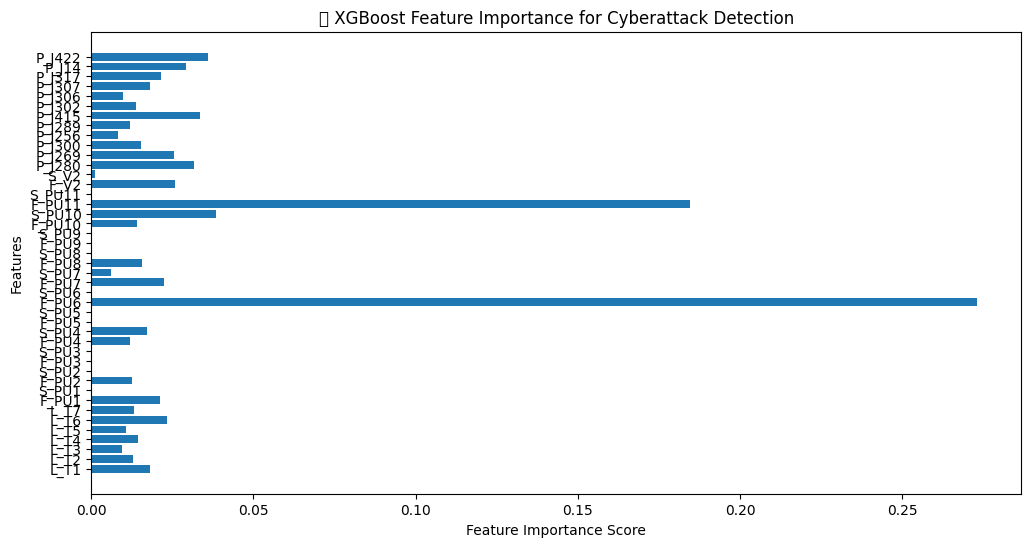

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance
importance = best_xgb.feature_importances_
features = X_train.columns

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(features, importance)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("🔹 XGBoost Feature Importance for Cyberattack Detection")
plt.show()


In [ ]:
# Drop extra columns to match training features
df_test = pd.read_csv("/content/drive/MyDrive/CWDS_DEMO/BATADAL Datasets/BATADAL_test.csv", parse_dates=['DATETIME'], dayfirst=True)
X_test_unlabeled = df_test.drop(columns=['DATETIME', 'ATT_FLAG'], errors='ignore')

# Ensure feature names match
print("Features in X_train:", list(X_train.columns))
print("Features in X_test_unlabeled:", list(X_test_unlabeled.columns))

# Predict anomalies
y_pred_test = best_xgb.predict(X_test_unlabeled)

# Add predictions to dataset
df_test['PREDICTED_ATTACK'] = y_pred_test

# Show first few rows
df_test.head()


Features in X_train: ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4', 'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8', 'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2', 'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']
Features in X_test_unlabeled: ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4', 'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8', 'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2', 'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']


<ipython-input-37-a07fed02ec22>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_test = pd.read_csv("/content/drive/MyDrive/CWDS_DEMO/BATADAL Datasets/BATADAL_test.csv", parse_dates=['DATETIME'], dayfirst=True)


,DATETIME,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,S_PU1,...,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422,ATT_FLAG,PREDICTED_ATTACK
0,2017-01-04 00:00:00,0.73,2.27,4.00,3.26,3.87,5.50,4.28,98.93,1.0,...,26.74,84.52,19.43,83.27,19.33,71.33,29.61,28.71,0.0,0
1,2017-01-04 01:00:00,0.69,2.25,4.53,3.26,3.84,5.50,4.78,97.95,1.0,...,26.73,85.04,25.97,64.22,25.86,73.79,29.63,28.73,0.0,0
2,2017-01-04 02:00:00,0.90,2.31,5.03,3.41,3.32,5.16,3.22,96.82,1.0,...,26.89,87.16,29.18,63.81,29.18,59.05,29.80,28.90,0.0,0
3,2017-01-04 03:00:00,1.11,2.54,5.16,3.97,2.82,5.01,2.54,96.76,1.0,...,28.23,88.83,26.53,63.42,26.41,70.92,30.80,29.90,0.0,0
4,2017-01-04 04:00:00,1.27,2.99,4.94,4.27,2.35,5.38,3.41,94.77,1.0,...,31.32,69.55,27.46,63.43,27.34,70.88,33.61,32.71,0.0,0


In [ ]:
from xgboost import XGBClassifier

# Retrain XGBoost with best parameters
best_xgb = XGBClassifier(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)
best_xgb.fit(X_train, y_train)

print("✅ Model retrained successfully!")


✅ Model retrained successfully!


In [ ]:
# Ensure only features used during training are present
expected_features = X_train.columns  # Get the exact training features
X_test_unlabeled = df_test[expected_features]  # Select only those columns

# Ensure the features match
print("✅ Features now match correctly!")


✅ Features now match correctly!


In [ ]:
# Ensure test dataset has the same feature order as training
X_test_unlabeled = X_test_unlabeled[X_train.columns]  # Reorder to match training

# Verify column order
print("Training Features:", list(X_train.columns))
print("Test Features:", list(X_test_unlabeled.columns))


Training Features: ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4', 'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8', 'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2', 'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']
Test Features: ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4', 'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8', 'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2', 'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']


In [ ]:
# Predict anomalies
df_test['PREDICTED_ATTACK'] = best_xgb.predict(X_test_unlabeled)

# Show first few rows with predictions
display(df_test.head())


,DATETIME,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,S_PU1,...,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422,ATT_FLAG,PREDICTED_ATTACK
0,2017-01-04 00:00:00,0.73,2.27,4.00,3.26,3.87,5.50,4.28,98.93,1.0,...,26.74,84.52,19.43,83.27,19.33,71.33,29.61,28.71,0.0,0
1,2017-01-04 01:00:00,0.69,2.25,4.53,3.26,3.84,5.50,4.78,97.95,1.0,...,26.73,85.04,25.97,64.22,25.86,73.79,29.63,28.73,0.0,0
2,2017-01-04 02:00:00,0.90,2.31,5.03,3.41,3.32,5.16,3.22,96.82,1.0,...,26.89,87.16,29.18,63.81,29.18,59.05,29.80,28.90,0.0,0
3,2017-01-04 03:00:00,1.11,2.54,5.16,3.97,2.82,5.01,2.54,96.76,1.0,...,28.23,88.83,26.53,63.42,26.41,70.92,30.80,29.90,0.0,0
4,2017-01-04 04:00:00,1.27,2.99,4.94,4.27,2.35,5.38,3.41,94.77,1.0,...,31.32,69.55,27.46,63.43,27.34,70.88,33.61,32.71,0.0,0


In [ ]:
df_test['PREDICTED_ATTACK'].value_counts()


,count
PREDICTED_ATTACK,
0,2027
1,62


In [ ]:
# Save the dataset with predictions
df_test.to_csv("/content/BATADAL_XGBoost_Predictions.csv", index=False)

print("✅ File saved! Ready for download.")


✅ File saved! Ready for download.
